In [1]:
import itertools
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, metrics

In [2]:
from layers import LinearLayer, LogisticLayer, LinearActivationLayer, SoftmaxOutputLayer
from network import MSNet

In [3]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [4]:
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap

In [5]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [6]:
sns.set_style('darkgrid')
np.random.seed(42)

### Linear function

In [7]:
def f(x):
    return x*2+5

x = np.random.uniform(0, 1, 100)
noise = np.random.randn(x.shape[0]) * 0.2
t = f(x) + noise

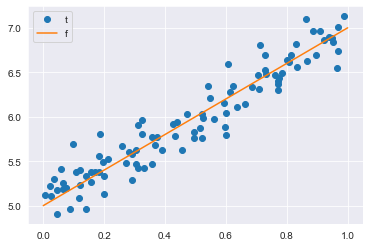

In [8]:
plt.plot(x, t, 'o', label='t')
plt.plot([0,1], [f(0), f(1)], label='f')
plt.legend()

In [9]:
X_train, X_test, T_train, T_test = model_selection.train_test_split(x.reshape(-1,1), t.reshape(-1,1), test_size=0.5, random_state=42)
X_validation, X_test, T_validation, T_test = model_selection.train_test_split(X_test, T_test, test_size=0.5, random_state=42)

In [10]:
X_test.shape, T_test.shape

((25, 1), (25, 1))

In [11]:
net = MSNet()

hidden_neurons_1 = 1

net.add_layer(LinearLayer(X_train.shape[1], hidden_neurons_1))
net.add_layer(LinearActivationLayer())

In [12]:
batch_size = 10
nb_of_batches = X_train.shape[0] // batch_size
XT_batches = list(zip(np.array_split(X_train, nb_of_batches, axis=0),
                      np.array_split(T_train, nb_of_batches, axis=0)))

In [13]:
batch_costs = []
train_costs = []
val_costs = []
max_epochs = 30
learning_rate = 0.1

for iteration in range(max_epochs):
    for X, T in XT_batches:
        activations = net.forward_step(X)
        batch_cost = net.layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        param_grads = net.backward_step(activations, T)
        net.update_params(param_grads, learning_rate)
    
    activations = net.forward_step(X_train)
    train_cost = net.layers[-1].get_cost(activations[-1], T_train)
    train_costs.append(train_cost)
    
    activations = net.forward_step(X_validation)
    validation_cost = net.layers[-1].get_cost(activations[-1], T_validation)
    val_costs.append(validation_cost)
    if (iteration + 1) % 10 == 0:
        print('Epoch', iteration+1, 'Training Loss:', train_cost)
    if len(val_costs) > 3:
        if val_costs[-1] >= val_costs[-2] >= val_costs[-3]:
            break

Epoch 10 Training Loss: 0.0007594015364439391
Epoch 20 Training Loss: 0.0007175670032678353
Epoch 30 Training Loss: 0.0006961441608191527


In [14]:
activations = net.forward_step(X_test)
y_pred = activations[-1]

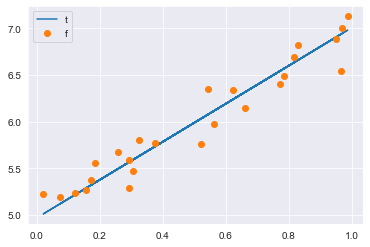

In [15]:
plt.plot(X_test, y_pred, label='t')
plt.plot(X_test, T_test, 'o',label='f')
plt.legend()

In [16]:
net.layers[-2].W, net.layers[-2].b

(array([[2.04017015]]), array([4.96766429]))

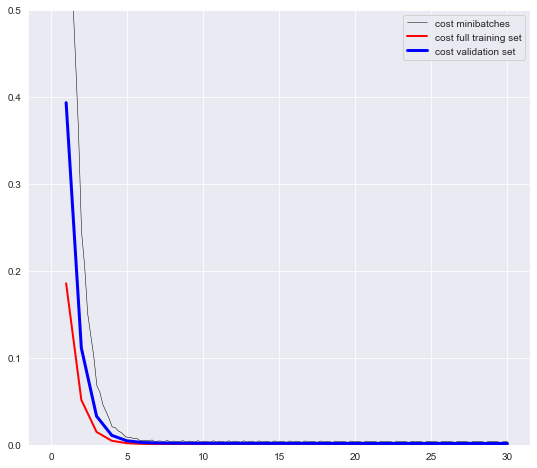

In [17]:
nb_of_iterations = iteration + 1
batch_x_inds = np.linspace(
    0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(
    1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.figure(figsize=(9, 8))
plt.plot(batch_x_inds, batch_costs, 
         'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, train_costs, 
         'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, val_costs, 
         'b-', linewidth=3, label='cost validation set')
plt.ylim(0,0.5)
plt.legend()

## Dataset Boston

In [18]:
boston = datasets.load_boston()
X = boston.data
Y = boston.target

In [19]:
scaler = StandardScaler()
X_train, X_test, T_train, T_test = model_selection.train_test_split(X, Y.reshape(-1,1), test_size=0.5, random_state=42)
X_validation, X_test, T_validation, T_test = model_selection.train_test_split(X_test, T_test, test_size=0.5, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, T_train.ravel())
mean_squared_error(T_test, lin_reg.predict(X_test))

30.790840990337344

In [21]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, T_train.ravel())
mean_squared_error(T_test, forest.predict(X_test))

17.67010344094487

In [22]:
boosting = GradientBoostingRegressor(random_state=42)
boosting.fit(X_train, T_train.ravel())
mean_squared_error(T_test, boosting.predict(X_test))

17.21075292178019

<AxesSubplot:ylabel='Count'>

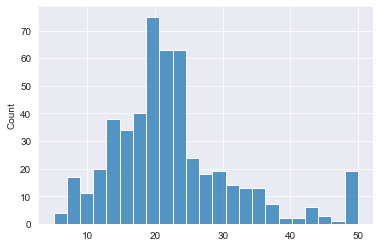

In [23]:
sns.histplot(Y)

In [24]:
batch_size = 32
nb_of_batches = X_train.shape[0] // batch_size
XT_batches = list(zip(np.array_split(X_train, nb_of_batches, axis=0),
                      np.array_split(T_train, nb_of_batches, axis=0)))

In [25]:
net = MSNet()

hidden_neurons_1 = 10
hidden_neurons_2 = 10

net.add_layer(LinearLayer(X_train.shape[1], hidden_neurons_1))
net.add_layer(LogisticLayer())
net.add_layer(LinearLayer(hidden_neurons_1, hidden_neurons_2))
net.add_layer(LogisticLayer())
net.add_layer(LinearLayer(hidden_neurons_2, 1))
net.add_layer(LinearActivationLayer())

In [26]:
batch_costs = []
train_costs = []
val_costs = []
max_epochs = 300
learning_rate = 0.03

for iteration in range(max_epochs):
    for X, T in XT_batches:
        activations = net.forward_step(X)
        batch_cost = net.layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        param_grads = net.backward_step(activations, T)
        net.update_params(param_grads, learning_rate)
    
    activations = net.forward_step(X_train)
    train_cost = net.layers[-1].get_cost(activations[-1], T_train)
    train_costs.append(train_cost)
    
    activations = net.forward_step(X_validation)
    validation_cost = net.layers[-1].get_cost(activations[-1], T_validation)
    val_costs.append(validation_cost)
    if (iteration + 1) % 10 == 0:
        print('Epoch', iteration+1, 'Training Loss:', train_cost)

Epoch 10 Training Loss: 0.15604043473087437
Epoch 20 Training Loss: 0.08991848675376267
Epoch 30 Training Loss: 0.0718936828053446
Epoch 40 Training Loss: 0.0630750446074099
Epoch 50 Training Loss: 0.05356605942022406
Epoch 60 Training Loss: 0.04480981072025703
Epoch 70 Training Loss: 0.03964676281238897
Epoch 80 Training Loss: 0.03641811938290525
Epoch 90 Training Loss: 0.0340218703594986
Epoch 100 Training Loss: 0.03201683822000141
Epoch 110 Training Loss: 0.030204421530033866
Epoch 120 Training Loss: 0.028528213001887782
Epoch 130 Training Loss: 0.027006887089273592
Epoch 140 Training Loss: 0.025658189353773415
Epoch 150 Training Loss: 0.024483762508515573
Epoch 160 Training Loss: 0.023468870653189818
Epoch 170 Training Loss: 0.022582842588557445
Epoch 180 Training Loss: 0.021786819255541243
Epoch 190 Training Loss: 0.021044076175698517
Epoch 200 Training Loss: 0.02034048667977995
Epoch 210 Training Loss: 0.0196943880837248
Epoch 220 Training Loss: 0.019121510595162153
Epoch 230 Tra

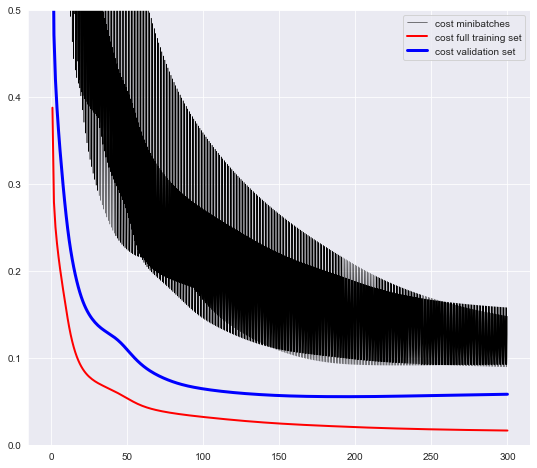

In [27]:
nb_of_iterations = iteration + 1
batch_x_inds = np.linspace(
    0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(
    1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.figure(figsize=(9, 8))
plt.plot(batch_x_inds, batch_costs, 
         'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, train_costs, 
         'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, val_costs, 
         'b-', linewidth=3, label='cost validation set')
plt.ylim(0,0.5)
plt.legend()

In [28]:
activations = net.forward_step(X_test)
y_pred = activations[-1]
mean_squared_error(T_test, y_pred)

21.73727830173371

## Classification

In [29]:
X, t = datasets.make_circles(
    n_samples=1000, shuffle=False, factor=0.3, noise=0.1)
T = np.zeros((1000, 2)) # Define target matrix
T[t==1, 1] = 1
T[t==0, 0] = 1
# Separate the red and blue samples for plotting
x_red = X[t==0]
x_blue = X[t==1]

In [30]:
X.shape, T.shape

((1000, 2), (1000, 2))

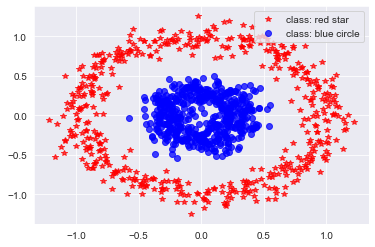

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(x_red[:,0], x_red[:,1], 'r*', 
         label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', 
         label='class: blue circle', alpha=0.75)
plt.legend(loc=1)

In [32]:
X_train, X_test, T_train, T_test = model_selection.train_test_split(X, T, test_size=0.5, random_state=42)
X_validation, X_test, T_validation, T_test = model_selection.train_test_split(X_test, T_test, test_size=0.5, random_state=42)

In [33]:
batch_size = 36
nb_of_batches = X_train.shape[0] // batch_size
XT_batches = list(zip(np.array_split(X_train, nb_of_batches, axis=0),
                      np.array_split(T_train, nb_of_batches, axis=0)))

In [34]:
net = MSNet()

hidden_neurons_1 = 3
hidden_neurons_2 = 2

net.add_layer(LinearLayer(X_train.shape[1], hidden_neurons_1))
net.add_layer(LogisticLayer())
net.add_layer(LinearLayer(hidden_neurons_1, T_train.shape[1]))
net.add_layer(SoftmaxOutputLayer())

In [35]:
batch_costs = []
train_costs = []
val_costs = []
max_epochs = 1000
learning_rate = 0.3

for iteration in range(max_epochs):
    for X, T in XT_batches:
        activations = net.forward_step(X)
        batch_cost = net.layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        param_grads = net.backward_step(activations, T)
        net.update_params(param_grads, learning_rate)
    
    activations = net.forward_step(X_train)
    train_cost = net.layers[-1].get_cost(activations[-1], T_train)
    train_costs.append(train_cost)
    
    activations = net.forward_step(X_validation)
    validation_cost = net.layers[-1].get_cost(activations[-1], T_validation)
    val_costs.append(validation_cost)
    if (iteration + 1) % 50 == 0:
        print('Epoch', iteration+1, 'Training Loss:', train_cost)

Epoch 50 Training Loss: 0.6958286221978339
Epoch 100 Training Loss: 0.694900194670996
Epoch 150 Training Loss: 0.6931403030133283
Epoch 200 Training Loss: 0.6577603813466076
Epoch 250 Training Loss: 0.4453593851213771
Epoch 300 Training Loss: 0.3386348221036629
Epoch 350 Training Loss: 0.12415211344744802
Epoch 400 Training Loss: 0.06414853494651118
Epoch 450 Training Loss: 0.0458299864288044
Epoch 500 Training Loss: 0.0370411904990577
Epoch 550 Training Loss: 0.03187044276097982
Epoch 600 Training Loss: 0.028445351504873855
Epoch 650 Training Loss: 0.025989610225397853
Epoch 700 Training Loss: 0.024125103158353752
Epoch 750 Training Loss: 0.022646521948704118
Epoch 800 Training Loss: 0.021433257320586808
Epoch 850 Training Loss: 0.020410086066062007
Epoch 900 Training Loss: 0.01952782632767128
Epoch 950 Training Loss: 0.018753070364638448
Epoch 1000 Training Loss: 0.018062396331870303


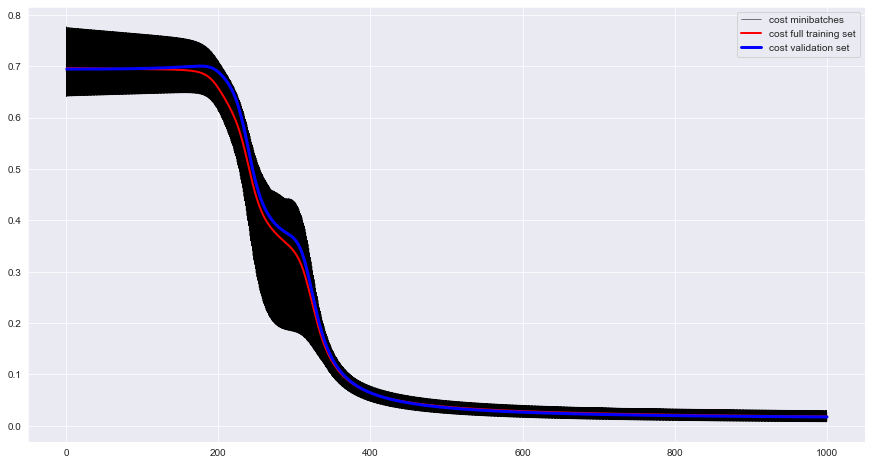

In [36]:
nb_of_iterations = iteration + 1
batch_x_inds = np.linspace(
    0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(
    1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.figure(figsize=(15, 8))
plt.plot(batch_x_inds, batch_costs, 
         'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, train_costs, 
         'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, val_costs, 
         'b-', linewidth=3, label='cost validation set')
plt.legend()

In [37]:
y_true = np.argmax(T_test, axis=1)
activations = net.forward_step(X_test)
y_pred = np.argmax(activations[-1], axis=1)
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'The accuracy on the test set is {test_accuracy:.0%}')

The accuracy on the test set is 100%


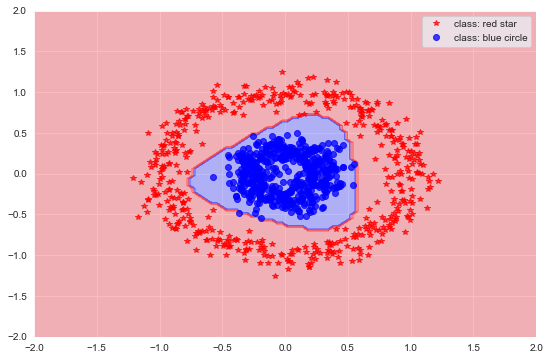

In [38]:
plt.figure(figsize=(9,6))
nb_of_xs = 100
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2)
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = np.around(net.forward_step(
            np.asarray([[xx[i,j], yy[i,j]]]))[-1])
#         print(pred)
        classification_plane[i,j] = pred[0, 0]
        
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.plot(x_red[:,0], x_red[:,1], 
         'r*', label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'bo', label='class: blue circle', alpha=0.75)
plt.legend(loc=1)

## Iris

In [39]:
iris = datasets.load_iris()
data = iris.data
target = iris.target

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
encoder = OneHotEncoder()
target = encoder.fit_transform(target.reshape(-1,1)).toarray()

In [42]:
scaler = StandardScaler()
X_train, X_test, T_train, T_test = model_selection.train_test_split(data, target, test_size=0.5, random_state=42)
X_validation, X_test, T_validation, T_test = model_selection.train_test_split(X_test, T_test, test_size=0.5, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [43]:
batch_size = 36
nb_of_batches = X_train.shape[0] // batch_size
XT_batches = list(zip(np.array_split(X_train, nb_of_batches, axis=0),
                      np.array_split(T_train, nb_of_batches, axis=0)))

In [44]:
net = MSNet()

hidden_neurons_1 = 2
hidden_neurons_2 = 2

net.add_layer(LinearLayer(X_train.shape[1], hidden_neurons_1))
net.add_layer(LogisticLayer())
net.add_layer(LinearLayer(hidden_neurons_1, T_train.shape[1]))
net.add_layer(SoftmaxOutputLayer())

In [45]:
batch_costs = []
train_costs = []
val_costs = []
max_epochs = 100
learning_rate = 0.1

for iteration in range(max_epochs):
    for X, T in XT_batches:
        activations = net.forward_step(X)
        batch_cost = net.layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        param_grads = net.backward_step(activations, T)
        net.update_params(param_grads, learning_rate)
    
    activations = net.forward_step(X_train)
    train_cost = net.layers[-1].get_cost(activations[-1], T_train)
    train_costs.append(train_cost)
    
    activations = net.forward_step(X_validation)
    validation_cost = net.layers[-1].get_cost(activations[-1], T_validation)
    val_costs.append(validation_cost)
    if (iteration + 1) % 10 == 0:
        print('Epoch', iteration+1, 'Training Loss:', train_cost)

Epoch 10 Training Loss: 1.0921459491407384
Epoch 20 Training Loss: 1.0872327826127297
Epoch 30 Training Loss: 1.0819589167516859
Epoch 40 Training Loss: 1.0722272009617306
Epoch 50 Training Loss: 1.054681626492229
Epoch 60 Training Loss: 1.0263108559350875
Epoch 70 Training Loss: 0.9866500486493082
Epoch 80 Training Loss: 0.9390259697316462
Epoch 90 Training Loss: 0.8887655942990207
Epoch 100 Training Loss: 0.8404000288576541


In [46]:
y_true = np.argmax(T_test, axis=1)
activations = net.forward_step(X_test)
y_pred = np.argmax(activations[-1], axis=1)
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'The accuracy on the test set is {test_accuracy:.0%}')

The accuracy on the test set is 92%


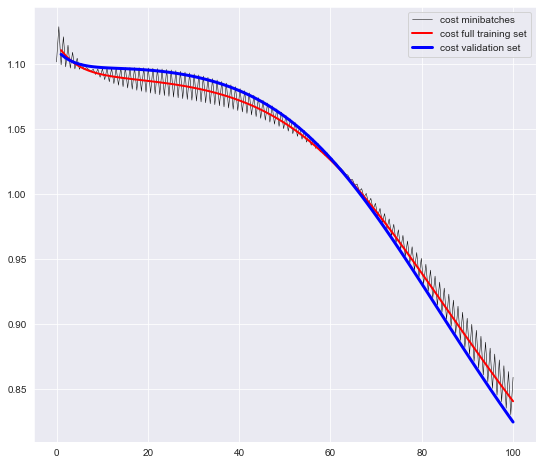

In [47]:
nb_of_iterations = iteration + 1
batch_x_inds = np.linspace(
    0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(
    1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.figure(figsize=(9, 8))
plt.plot(batch_x_inds, batch_costs, 
         'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, train_costs, 
         'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, val_costs, 
         'b-', linewidth=3, label='cost validation set')
plt.legend()

## Mnist

In [48]:
digits = datasets.load_digits()
T = np.zeros((digits.target.shape[0], 10))
T[np.arange(len(T)), digits.target] += 1
T

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [49]:
X_train, X_test, T_train, T_test = model_selection.train_test_split(digits.data, T, test_size=0.5, random_state=42)
X_validation, X_test, T_validation, T_test = model_selection.train_test_split(X_test, T_test, test_size=0.5, random_state=42)

In [50]:
X_train.shape

(898, 64)

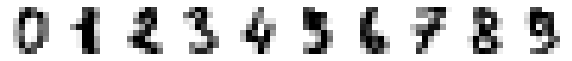

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(10, 1))
for i, ax in enumerate(axs):
    ax.imshow(digits.images[i], cmap='binary') 
    ax.set_axis_off()

In [52]:
net = MSNet()

hidden_neurons_1 = 20
hidden_neurons_2 = 20

net.add_layer(LinearLayer(X_train.shape[1], hidden_neurons_1))
net.add_layer(LogisticLayer())
net.add_layer(LinearLayer(hidden_neurons_1, hidden_neurons_2))
net.add_layer(LogisticLayer())
net.add_layer(LinearLayer(hidden_neurons_2, T_train.shape[1]))
net.add_layer(SoftmaxOutputLayer())

In [53]:
batch_size = 25
nb_of_batches = X_train.shape[0] // batch_size
XT_batches = list(zip(np.array_split(X_train, nb_of_batches, axis=0),
                      np.array_split(T_train, nb_of_batches, axis=0)))

In [54]:
batch_costs = []
train_costs = []
val_costs = []
max_epochs = 30
learning_rate = 0.3

for iteration in range(max_epochs):
    for X, T in XT_batches:
        activations = net.forward_step(X)
        batch_cost = net.layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        param_grads = net.backward_step(activations, T)
        net.update_params(param_grads, learning_rate)
    
    activations = net.forward_step(X_train)
    train_cost = net.layers[-1].get_cost(activations[-1], T_train)
    train_costs.append(train_cost)
    
    activations = net.forward_step(X_validation)
    validation_cost = net.layers[-1].get_cost(activations[-1], T_validation)
    val_costs.append(validation_cost)
    if (iteration + 1) % 1 == 0:
        print('Epoch', iteration+1, 'Training Loss:', train_cost)

Epoch 1 Training Loss: 2.2728461632716774
Epoch 2 Training Loss: 2.1699648423300273
Epoch 3 Training Loss: 1.9333640155791796
Epoch 4 Training Loss: 1.6491073358159267
Epoch 5 Training Loss: 1.3932767622581312
Epoch 6 Training Loss: 1.1754096555973794
Epoch 7 Training Loss: 0.9934712708842646
Epoch 8 Training Loss: 0.8425078740910767
Epoch 9 Training Loss: 0.7076674963882184
Epoch 10 Training Loss: 0.6331196751774163
Epoch 11 Training Loss: 0.5193509922885398
Epoch 12 Training Loss: 0.4407003401900733
Epoch 13 Training Loss: 0.3606945555890778
Epoch 14 Training Loss: 0.3192083704003326
Epoch 15 Training Loss: 0.26857694106639907
Epoch 16 Training Loss: 0.2475300199138063
Epoch 17 Training Loss: 0.22087616631337328
Epoch 18 Training Loss: 0.2272655828731937
Epoch 19 Training Loss: 0.2300191421831199
Epoch 20 Training Loss: 0.25038386253815875
Epoch 21 Training Loss: 0.18492956964443721
Epoch 22 Training Loss: 0.2265643127337623
Epoch 23 Training Loss: 0.17422536708203815
Epoch 24 Traini

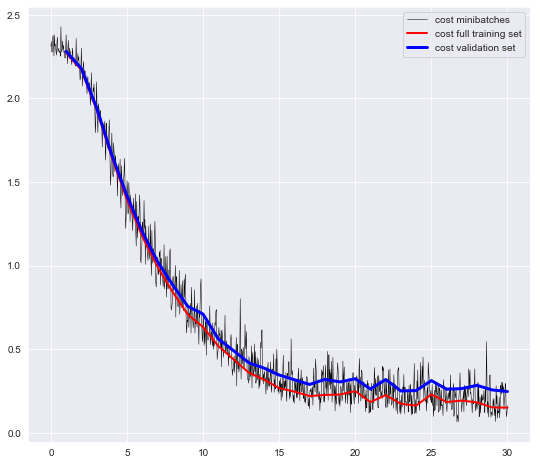

In [55]:
nb_of_iterations = iteration + 1
batch_x_inds = np.linspace(
    0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(
    1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.figure(figsize=(9, 8))
plt.plot(batch_x_inds, batch_costs, 
         'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, train_costs, 
         'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, val_costs, 
         'b-', linewidth=3, label='cost validation set')
plt.legend()

In [56]:
y_true = np.argmax(T_test, axis=1)
activations = net.forward_step(X_test)
y_pred = np.argmax(activations[-1], axis=1)
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'The accuracy on the test set is {test_accuracy:.0%}')

The accuracy on the test set is 91%
